# Analyse de l'impact des gros festivals sur les autres

**L'objectif de cette partie est de regarder comment des festivals importants (en taille) impactent les autres festivals aux alentours.**
<br> **On scrappe alors des données sur un site internet pour récupérer le nom de gros festivals (10 plus gros ou 50 plus gros), ensuite on cherche ces festivals dans notre base de données principale**
<br> **Ces gros festivals et leur correspondance dans la base principale sont stockés dans le dataframe festival_fusionnes_complets.csv, et nous allons donc utiliser ce dataframe**¨

## I. Statistiques descriptives des gros festivals

On veut afficher une carte avec les gros festival et un histogramme avec la saison des festivals.

In [1]:
!pip install cartiflette pandas geopandas matplotlib

### I.1. Carte des gros festivals

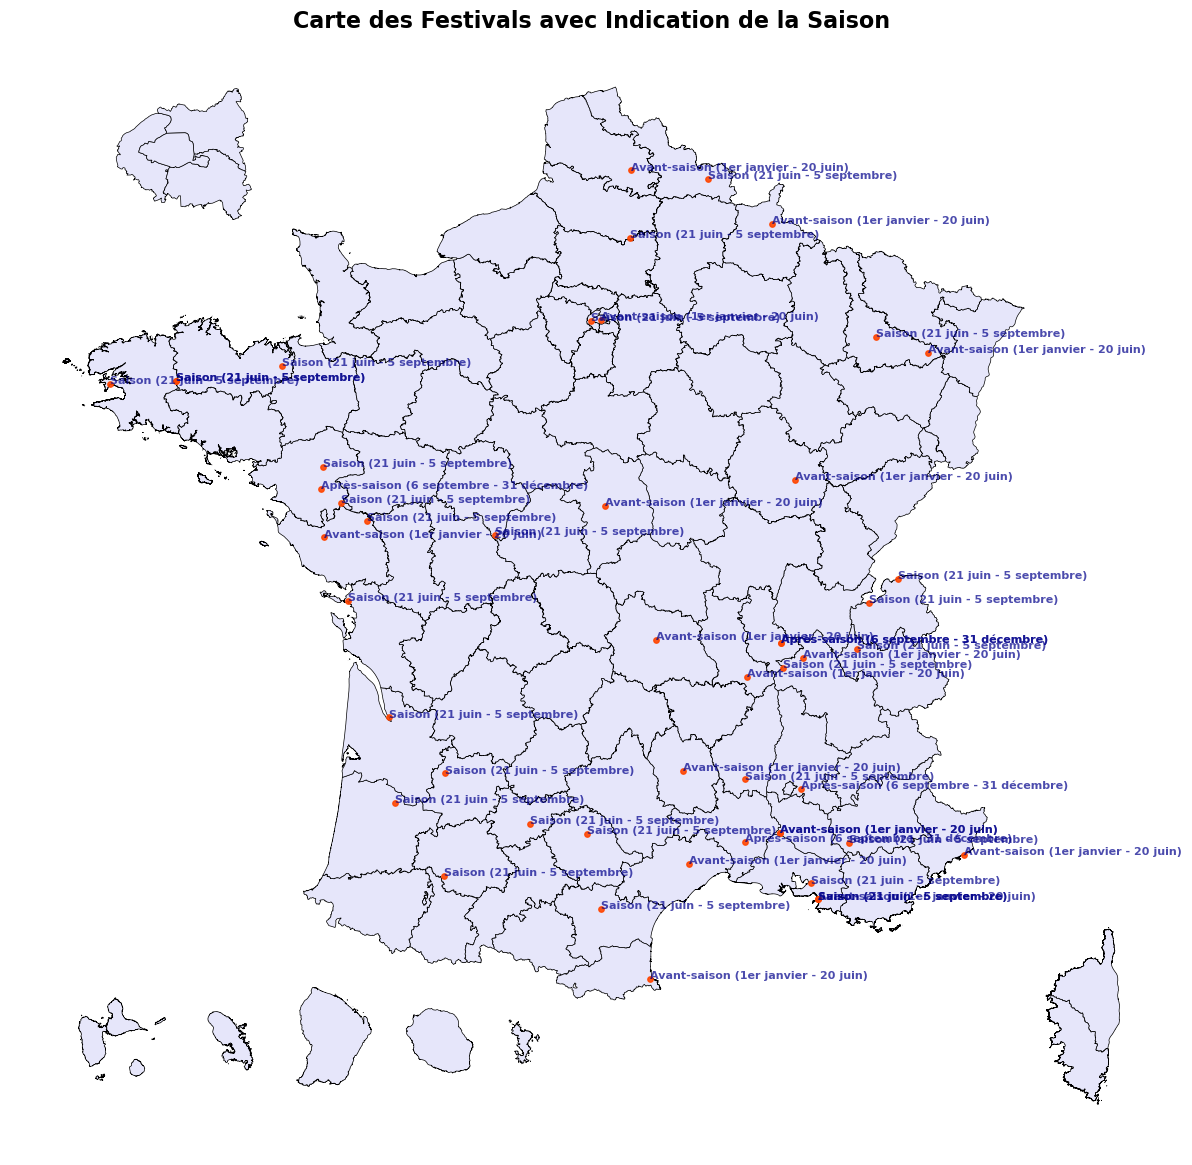

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Rechargement des données
file_path = "festivals_fusionnes_complets.csv"
df = pd.read_csv(file_path)

# Conversion des données en GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_france"], df["Latitude_france"]),
    crs="EPSG:4326"
)

# Téléchargement des limites des départements
departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Création d'une carte des festivals avec des couleurs améliorées pour plus de lisibilité
fig, ax = plt.subplots(figsize=(15, 15))
departements.plot(ax=ax, color="#E6E6FA", edgecolor="black", linewidth=0.5)  # Fond de carte en lavande
gdf.plot(ax=ax, color="#FF4500", markersize=15, alpha=0.9)  # Points des festivals en orange vif

# Ajout des annotations pour les saisons
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Période principale de déroulement du festival"]):
    ax.text(x, y, label, fontsize=8, color="darkblue", alpha=0.7, weight="bold")

# Personnalisation de la mise en page
ax.set_title("Carte des Festivals avec Indication de la Saison", fontsize=16, fontweight="bold")
ax.set_facecolor("#F5F5F5")  # Arrière-plan doux
plt.axis("off")
plt.show()

On remarque qu'on a une grande concentration de gros festivals dans le sud de la France (à la fois est et ouest) ainsi que dans la Loire et en Rhône Alpes.

### I.2. Histogramme du nombre de festivals par saison

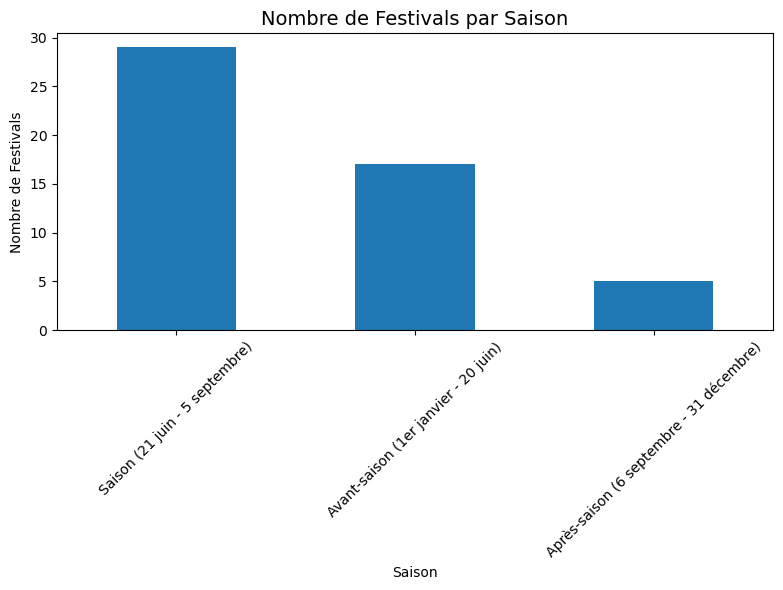

In [3]:
# Création d'un histogramme du nombre de festivals par saison
fig, ax = plt.subplots(figsize=(8, 6))
df["Période principale de déroulement du festival"].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Nombre de Festivals par Saison", fontsize=14)
ax.set_xlabel("Saison")
ax.set_ylabel("Nombre de Festivals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comme les gros festivals sont principalement des festivals de musique, alors on remarque qu'ils sont principalement pendant la saison et très peu dans l'après-saison.

Maintenant on analyse les cartes suivant la saisonnalité.

### I.3. Carte en fonction des saisons

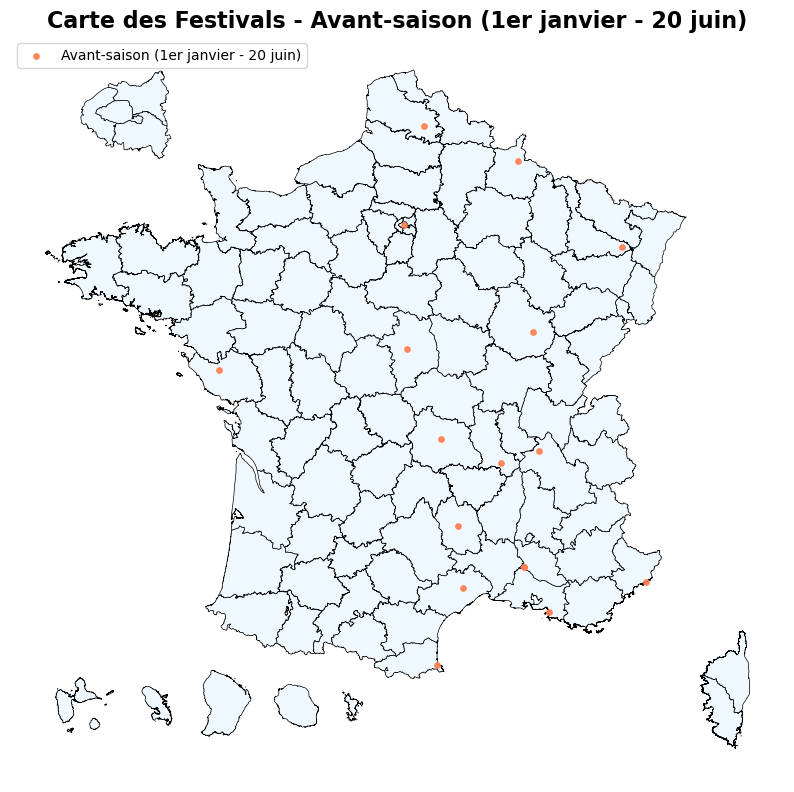

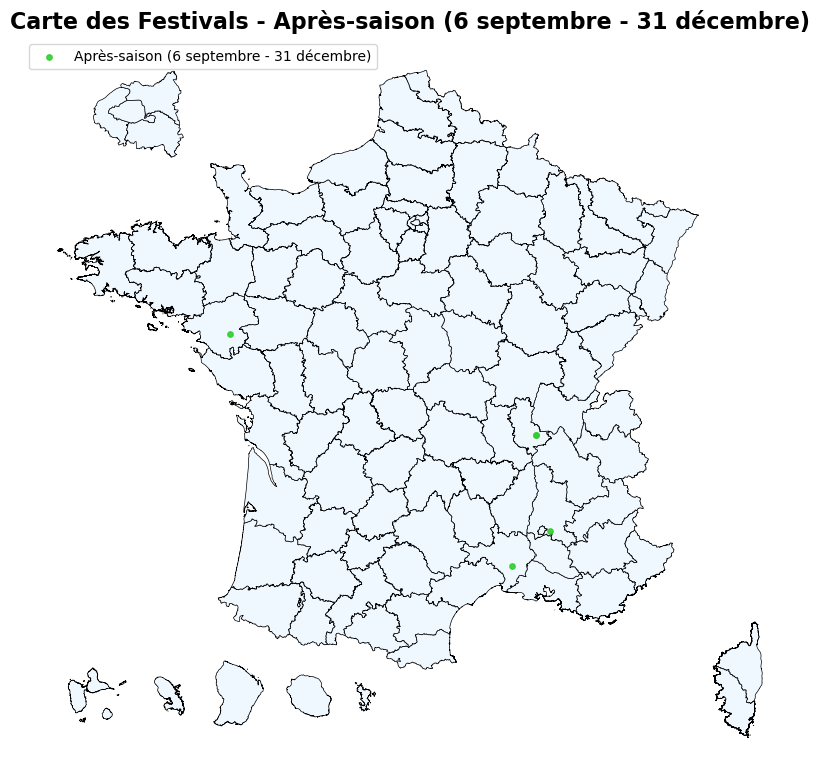

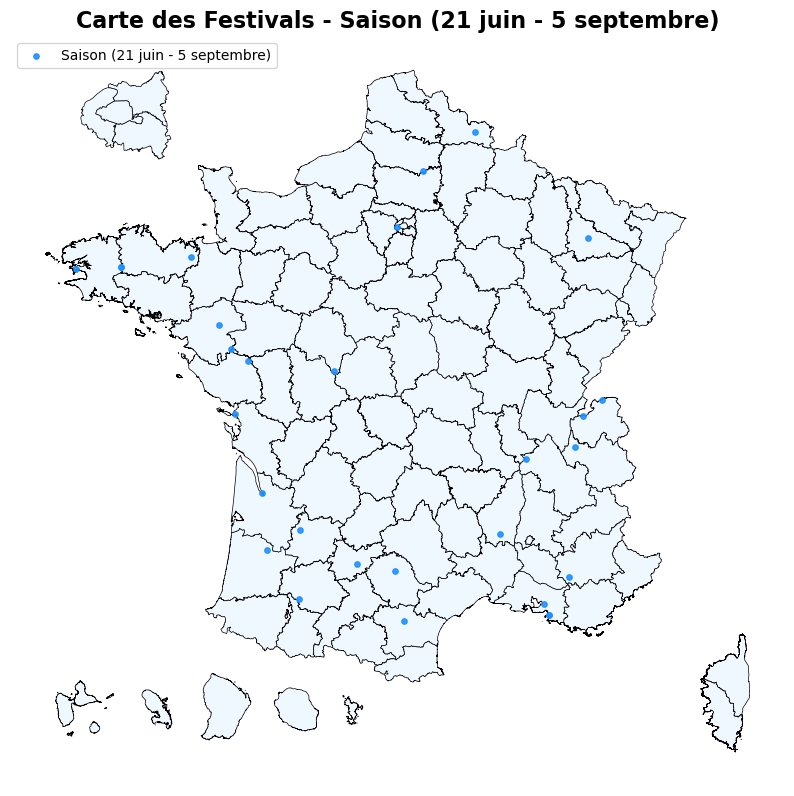

In [4]:
# Importation des bibliothèques nécessaires après le reset
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Rechargement des données nécessaires
file_path = "festivals_fusionnes_complets.csv"
df = pd.read_csv(file_path)

# Conversion des données en GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_france"], df["Latitude_france"]),
    crs="EPSG:4326"
)

# Téléchargement des limites des départements
departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Création de trois cartes distinctes pour chaque saisonnalité

# Définition des périodes
seasons = ["Avant-saison (1er janvier - 20 juin)", "Après-saison (6 septembre - 31 décembre)", "Saison (21 juin - 5 septembre)"]
colors = {"Avant-saison (1er janvier - 20 juin)": "#FF7F50", "Après-saison (6 septembre - 31 décembre)": "#32CD32", "Saison (21 juin - 5 septembre)": "#1E90FF"}

for season in seasons:
    # Filtrer les données pour la saison
    season_data = gdf[gdf["Période principale de déroulement du festival"] == season]
    
    # Filtrer les géométries nulles
    season_data = season_data[season_data.geometry.notnull()]
    
    # Vérifier si les données sont disponibles pour cette saison
    if season_data.empty:
        print(f"Aucune donnée disponible pour la saison : {season}")
        continue
    
    # Création de la carte
    fig, ax = plt.subplots(figsize=(10, 10))
    departements.plot(ax=ax, color="#F0F8FF", edgecolor="black", linewidth=0.5)  # Fond de carte
    season_data.plot(ax=ax, color=colors[season], markersize=15, alpha=0.9, label=season)  # Points pour la saison
    
    # Personnalisation de la carte
    ax.set_title(f"Carte des Festivals - {season}", fontsize=16, fontweight="bold")
    ax.set_facecolor("#F5F5F5")  # Arrière-plan doux
    plt.axis("off")
    plt.legend(loc="upper left", fontsize=10)
    plt.show()

Ce qu'on souhaite analyser avec ces cartes est comment les gros festivals se répartissent à la fois dans le temps et dans l'espace. On se doute que si un gros festival à lieu à une certaine date et à un certain lieu, alors un autre gros festival n'aura pas lieu à proximité et dans un intervalle de temps restreint.
Les données que nous utilisons ne sont pas précises à 100% car il se peut que 2 festivals soient à 1 jour d'écart mais soient dans des catégories de saisons différentes (par exemple le 5 septembre et le 6 septembre), mais nous considérons les saisons comme la meilleure approximation dont nous disposons.

Ce qu'on peut remarquer alors est que par rapport à la première carte avec des gros pôles de festivals, ici, les festivals sont plus éloignés (en lieu) et donc l'effet de la concurrence se fait sentir. En effet, pour attirer de la foule, il faut que les festivals soient espacés (en lieu et date). 

Mais qu'en est il avec les autres petits festivals ?

## II. Impact des gros festivals sur les plus petits

In [6]:
# Importer le fichier comme un module
from Nettoyage_base_donnees import df
df_petits_festivals = df

# Vérifier le contenu du DataFrame
print(df_petits_festivals.head())

Contenu du dossier diffusion :
['arthurneau/diffusion/.keep', 'arthurneau/diffusion/festivals_en_France (1).csv']
Fichier chargé avec succès :
           ﻿Nom du festival Envergure territoriale  \
0          Festival andalou              Régionale   
1  Festival Rêves d'enfants                    NaN   
2      Printemps de Paroles                    NaN   
3                 Pharaonic                    NaN   
4           Sarcus Festival                    NaN   

  Région principale de déroulement Département principal de déroulement  \
0       Provence-Alpes-Côte d'Azur                             Vaucluse   
1       Provence-Alpes-Côte d'Azur                         Hautes-Alpes   
2                    Île-de-France                       Seine-et-Marne   
3             Auvergne-Rhône-Alpes                               Savoie   
4              Centre-Val de Loire                       Indre-et-Loire   

  Commune principale de déroulement  \
0                           Avignon   
1  

### II.1. Analyse à partir de la zone géographique

L'idée qu'on met en place est la suivante : on compte le nombre de petits festivals dans un cercle de 50km de rayon et le nombre de festivals dans un anneau de cercle intérieur de 50km et de cercle extérieur de 100km. On divise ensuite ces nombre par la surface de chaque forme géométrique pour avoir un nombre normalisé en nombre de festivals par km^2. On fait une moyenne sur tous les gros festivals et on compare ces nombres.

In [27]:
# Bibliothèques nécessaires
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# Charger les données
file_path = "festivals_fusionnes_complets.csv"
df_gros_festivals = pd.read_csv(file_path)

# Rayon et surfaces
rayon_50 = 50  # km
rayon_100 = 100  # km
surface_50 = np.pi * (rayon_50**2)
surface_anneau = np.pi * (rayon_100**2 - rayon_50**2)

# Initialiser les résultats
results = []

# Calculer pour chaque gros festival
for _, gros in df_gros_festivals.iterrows():
    lat_gros, lon_gros = gros["Latitude_france"], gros["Longitude_france"]
    saison_gros = gros["Période principale de déroulement du festival"]  # Nom réel de la colonne pour la saison
    nom_gros = gros["Festival match"]  # Colonne identifiant le nom du gros festival
    
    # Compteur pour les petits festivals
    count_50 = 0
    count_anneau = 0
    
    for _, petit in df_petits_festivals.iterrows():
        # Vérification de la saison et exclusion des gros festivals
        if (
            isinstance(petit["Géocodage xy"], str)
            and petit["Période principale de déroulement du festival"] == saison_gros
            and petit["Nom du festival"] != nom_gros  # Exclure le gros festival
        ):
            try:
                # Extraction des coordonnées
                lat_petit, lon_petit = map(float, petit["Géocodage xy"].split(','))
            except ValueError:
                continue  # Ignorer les valeurs mal formatées
        else:
            continue  # Ignorer les lignes non conformes ou de saison différente
        
        # Calcul de la distance entre les festivals
        distance = geodesic((lat_gros, lon_gros), (lat_petit, lon_petit)).km
        
        # Comptage selon les distances
        if distance <= rayon_50:
            count_50 += 1
        elif rayon_50 < distance <= rayon_100:
            count_anneau += 1
    
    # Normaliser par la surface
    density_50 = count_50 / surface_50
    density_anneau = count_anneau / surface_anneau
    
    # Sauvegarder les résultats pour ce gros festival
    results.append({
        "Gros_Festival": nom_gros,
        "Density_50": density_50,
        "Density_Donut": density_anneau
    })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Calculer les moyennes sur tous les gros festivals
average_density_50 = results_df["Density_50"].mean()
average_density_anneau = results_df["Density_Donut"].mean()

# Afficher les résultats
print("Moyenne de densité (0-50 km):", average_density_50)
print("Moyenne de densité (50-100 km):", average_density_anneau)

Moyenne de densité (0-50 km): 0.00636120462742195
Moyenne de densité (50-100 km): 0.0038130611725336696


Voici les résultats que nous obtenons : 
<br> Moyenne de densité (0-50 km): 0.00636120462742195
<br> Moyenne de densité (50-100 km): 0.0038130611725336696

Il semble alors qu'il y ait plus de festivals dans un rayon de 50km que dans un anneau de rayon intérieur de 50km et rayon extérieur de 100km, pendant la même saison. Cela est contre-intuitif à ce que nous pensions au début, à savoir que les gros festivals ont des impacts négatifs sur le nombre de petits festivals aux alentours.

Il faut néanmoins prendre en compte le biais concernant les pôles de festivals. C'est à dire qu'il y a des zones géographiques avec une forte concentration de festivals, choses qu'on ne peut pas extraire de l'analyse. Cette version n'est donc pas très satisfaisante, car ce biais reste relativement important.

### II.2. Analyse à partir de la temporalité

Regardons maintenant d'un autre point de vue, à savoir sur la période. On compare sur une même zone géographique si lors de la saison du gros festival, il y a moins de petits festivals que lors des autres saisons. Il faut alors comparer ces données avec les données agrégées au niveau France sur le nombre de festivals par saison. On rappelle l'histogramme ci-dessous :

Période principale de déroulement du festival
Saison (21 juin - 5 septembre)              2611
Avant-saison (1er janvier - 20 juin)        2357
Après-saison (6 septembre - 31 décembre)    1840
Name: count, dtype: int64


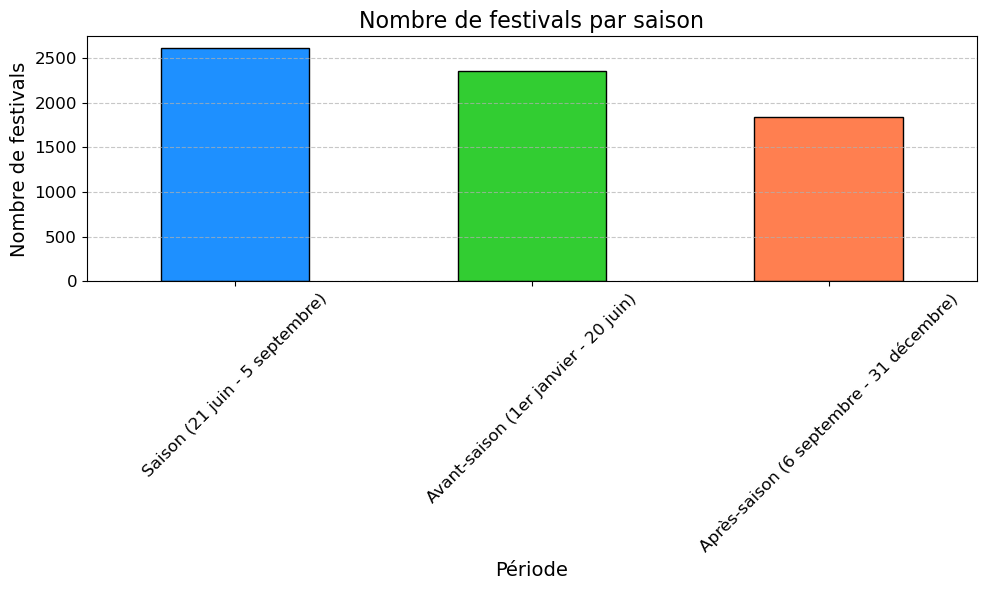

In [33]:
# Réimportation des bibliothèques nécessaires après le reset
import pandas as pd
import matplotlib.pyplot as plt

# Comptage du nombre de festivals par saison
festival_counts = df_petits_festivals["Période principale de déroulement du festival"].value_counts()

print(festival_counts)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
festival_counts.plot(kind="bar", color=["#1E90FF", "#32CD32", "#FF7F50"], edgecolor="black")

# Personnalisation du graphique
plt.title("Nombre de festivals par saison", fontsize=16)
plt.xlabel("Période", fontsize=14)
plt.ylabel("Nombre de festivals", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Affichage de l'histogramme
plt.tight_layout()
plt.show()

Maintenant on regarde les données pour comparer.

In [ ]:
import numpy as np
from geopy.distance import geodesic
# Rayon géographique en km
radius_50 = 50

# Données globales au niveau de la France
national_data = {
    "Saison": 2611,
    "Avant-saison": 2357,
    "Après-saison": 1840
}

# Initialiser les résultats pour chaque catégorie de gros festivals
final_results = {
    "Gros festivals Avant-saison": {"Avant-saison (1er janvier - 20 juin)": [], "Saison (21 juin - 5 septembre)": [], "Après-saison (6 septembre - 31 décembre)": []},
    "Gros festivals Saison": {"Avant-saison (1er janvier - 20 juin)": [], "Saison (21 juin - 5 septembre)": [], "Après-saison (6 septembre - 31 décembre)": []},
    "Gros festivals Après-saison": {"Avant-saison (1er janvier - 20 juin)": [], "Saison (21 juin - 5 septembre)": [], "Après-saison (6 septembre - 31 décembre)": []}
}

# Calculer pour chaque gros festival
for _, gros in df_gros_festivals.iterrows():
    lat_gros, lon_gros = gros["Latitude_france"], gros["Longitude_france"]
    saison_gros = gros["Période principale de déroulement du festival"]
    
    # Compter les petits festivals par saison dans un rayon de 50 km
    local_counts = {"Avant-saison (1er janvier - 20 juin)": 0, "Saison (21 juin - 5 septembre)": 0, "Après-saison (6 septembre - 31 décembre)": 0}
    
    for _, petit in df_petits_festivals.iterrows():
        if isinstance(petit["Géocodage xy"], str):
            try:
                # Extraire les coordonnées des petits festivals
                lat_petit, lon_petit = map(float, petit["Géocodage xy"].split(','))
                
                # Calculer la distance
                distance = geodesic((lat_gros, lon_gros), (lat_petit, lon_petit)).km
                
                # Vérifier si le festival est dans un rayon de 50 km
                if distance <= radius_50:
                    saison_petit = petit["Période principale de déroulement du festival"]
                    if saison_petit in local_counts:
                        local_counts[saison_petit] += 1
            except ValueError:
                continue  # Ignorer les données mal formatées
    
    # Ajouter les résultats pour ce gros festival dans la catégorie correspondante
    if saison_gros == "Avant-saison (1er janvier - 20 juin)":
        for saison, count in local_counts.items():
            final_results["Gros festivals Avant-saison"][saison].append(count)
    elif saison_gros == "Saison (21 juin - 5 septembre)":
        for saison, count in local_counts.items():
            final_results["Gros festivals Saison"][saison].append(count)
    elif saison_gros == "Après-saison (6 septembre - 31 décembre)":
        for saison, count in local_counts.items():
            final_results["Gros festivals Après-saison"][saison].append(count)

# Calculer les moyennes pour chaque combinaison
average_results = {}
for category, data in final_results.items():
    average_results[category] = {saison: np.mean(counts) for saison, counts in data.items()}

# Normaliser les moyennes par les données nationales
season_mapping = {
    "Avant-saison (1er janvier - 20 juin)": "Avant-saison",
    "Saison (21 juin - 5 septembre)": "Saison",
    "Après-saison (6 septembre - 31 décembre)": "Après-saison"
}
normalized_results = {}
for category, averages in average_results.items():
    normalized_results[category] = {
        saison: averages[saison] / national_data[season_mapping[saison]] for saison in averages
    }

print("\nRésultats normalisés par les données nationales :")
for category, data in normalized_results.items():
    print(f"{category}:")
    for saison, value in data.items():
        print(f"  {saison}: {value:.3f}")


Résultats normalisés par les données nationales :
Gros festivals Avant-saison:
  Avant-saison (1er janvier - 20 juin): 0.024
  Saison (21 juin - 5 septembre): 0.020
  Après-saison (6 septembre - 31 décembre): 0.025
Gros festivals Saison:
  Avant-saison (1er janvier - 20 juin): 0.020
  Saison (21 juin - 5 septembre): 0.018
  Après-saison (6 septembre - 31 décembre): 0.022
Gros festivals Après-saison:
  Avant-saison (1er janvier - 20 juin): 0.029
  Saison (21 juin - 5 septembre): 0.021
  Après-saison (6 septembre - 31 décembre): 0.029


Voici les résultats que nous obtenus à date : 

Résultats normalisés par les données nationales :
Gros festivals Avant-saison:
  Avant-saison (1er janvier - 20 juin): 0.024
  Saison (21 juin - 5 septembre): 0.020
  Après-saison (6 septembre - 31 décembre): 0.025
Gros festivals Saison:
  Avant-saison (1er janvier - 20 juin): 0.020
  Saison (21 juin - 5 septembre): 0.018
  Après-saison (6 septembre - 31 décembre): 0.022
Gros festivals Après-saison:
  Avant-saison (1er janvier - 20 juin): 0.029
  Saison (21 juin - 5 septembre): 0.021
  Après-saison (6 septembre - 31 décembre): 0.029

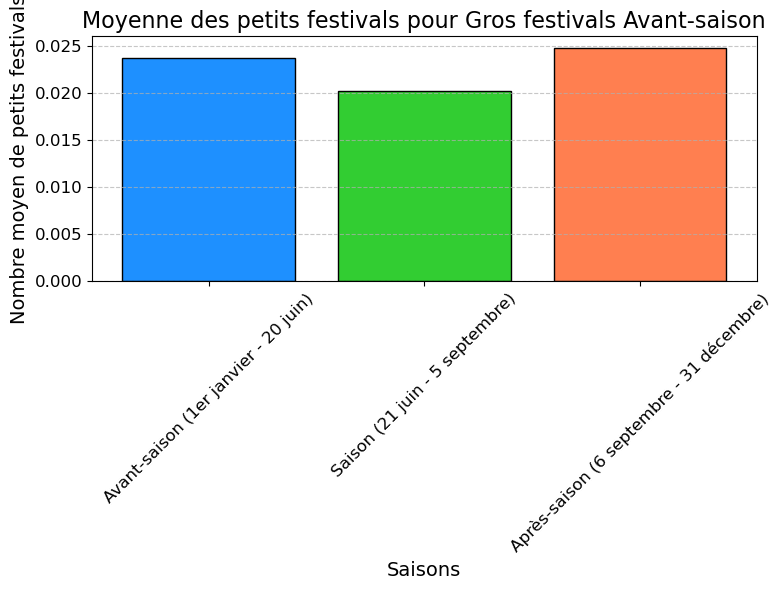

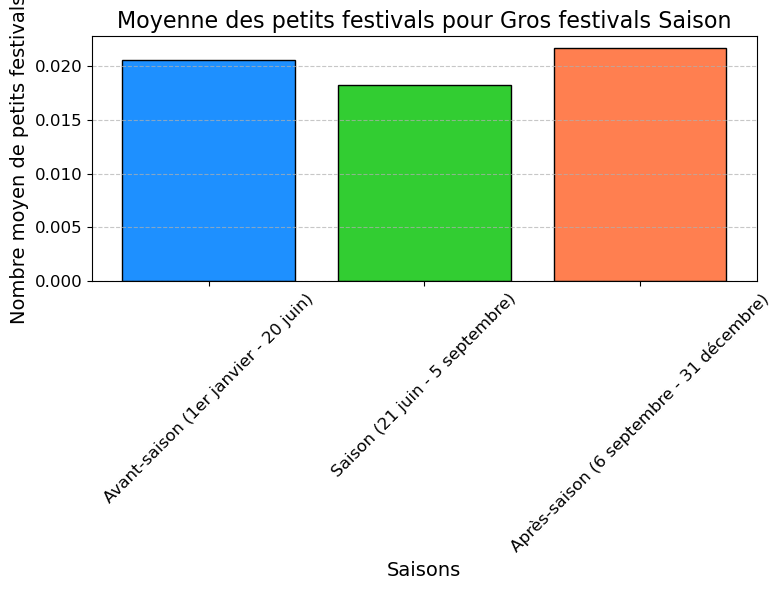

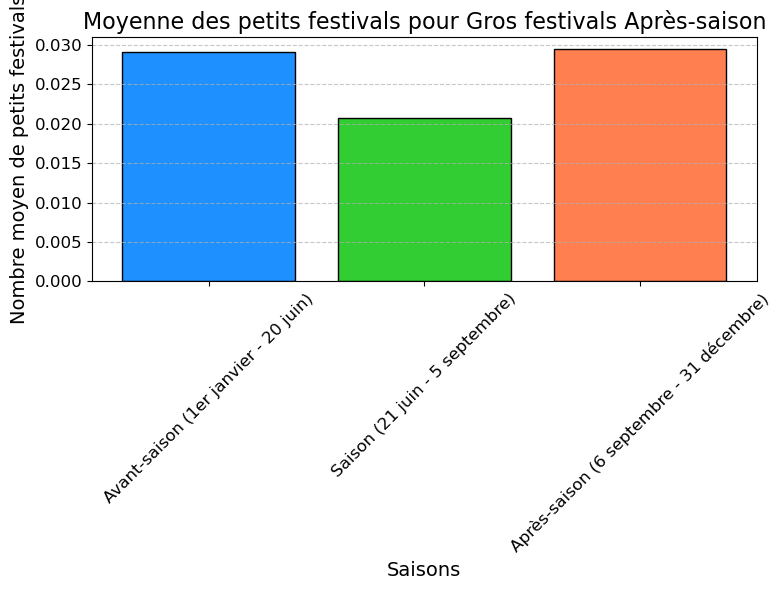

In [ ]:
import matplotlib.pyplot as plt
# Génération des histogrammes
categories = list(average_results.keys())
seasons = list(final_results["Gros festivals Avant-saison"].keys())

for category in categories:
    # Extraire les données pour la catégorie
    values = [normalized_results[category][season] for season in seasons]
    
    # Création de l'histogramme
    plt.figure(figsize=(8, 6))
    plt.bar(seasons, values, color=["#1E90FF", "#32CD32", "#FF7F50"], edgecolor="black")
    
    # Personnalisation du graphique
    plt.title(f"Moyenne des petits festivals pour {category}", fontsize=16)
    plt.xlabel("Période", fontsize=14)
    plt.ylabel("Nombre moyen de petits festivals", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Affichage
    plt.tight_layout()
    plt.show()

Les résultats sont mitigés. Concernant les gros festivals ayant lieu durant l'avant-saison et l'après-saison, on peut remarquer qu'il y aura plus de petits festivals aux alentours durant cette période, les gros festivals fonctionnant comme un attracteur de petits festivals. Concernant les festivals durant la saison, alors il y aura moins de petits festivals aux alentours.

Ces résultats sont néanmoins à interpréter avec délicatesse par rapport à la précision de la période. Nous avons juste l'information sur la période, pas plus.